In [128]:
from glob import glob

import cv2

import pandas as pd
import os
import pickle
import numpy as np
import tkinter as tk
import json
import datetime
from math import sqrt


In [8]:
from check_wifi_signal import bibs, bibs_files, subject2id, read_BLE_data

In [6]:
bibs_files()

In [18]:
def calculate_center(bbox):
    """Calculate the center point of a bounding box."""
    x, y, width, height = bbox
    return x + width / 2, y + height / 2

def calculate_distance(p1, p2):
    """Calculate Euclidean distance between two points."""
    return sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)


In [9]:
ble_df = read_BLE_data()

In [10]:
ble_df

,id,time,mac,rssi
0,1,1.727910e+09,a0:66:10:af:ff:f5,-93
1,1,1.727910e+09,a0:66:10:af:ff:f5,-103
2,1,1.727910e+09,a0:66:10:af:ff:f5,-101
3,1,1.727910e+09,a0:66:10:af:ff:f5,-107
4,1,1.727910e+09,a0:66:10:af:ff:f5,-92
...,...,...,...,...
137,34,1.727916e+09,a0:66:10:af:ff:f6,-92
138,34,1.727916e+09,a0:66:10:af:ff:f6,-86
139,34,1.727916e+09,a0:66:10:af:ff:f6,-93
140,34,1.727916e+09,a0:66:10:af:ff:f6,-92


In [11]:
ble_df[ble_df['mac'] == "a0:66:10:af:ff:f6"].groupby(["id"]).size()

id
0      6351
1       314
2      1014
3      2633
4       487
5      4288
6      1077
7       407
8      4795
9      1282
10     1965
11     3576
13      786
16     3614
17      703
19     1229
20     1122
21     2544
23     1641
24      108
25     3796
27       95
32     1022
33    10250
34      873
35      399
36     1386
37     1465
38     6345
dtype: int64

In [12]:
len(bibs)

39

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.cm as cm

# Assign a unique color to each area dynamically using a colormap
cmap = cm.get_cmap('tab20', len(bibs))


/tmp/ipykernel_643843/3312884230.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(bibs))


In [17]:
def load_json_file(file):
    with open(file, 'r') as f:
        workers = json.load(f)
    return workers

In [166]:


def make_worker_df():
    results = []
    target_frames = 9000
    workers = load_json_file("/mnt/vanda/01_projects/2024_trusco/20241003-track/1106tracking_result_20241003_worker_body_1100_1200_updated.json")

    subjs=[]
    for i in range(0,39):
        subjs.append(())

    print(len(workers))
# Loop through each frame and track
    for frame in workers[:target_frames]:
        frame_id = frame["frame_id"]
        for track in frame["tracks"]:
            lastx = -1
            try:
                subj_id = int(track["subj_id"])
                if subj_id <0 or subj_id > 38:
                    print("Out!",subj_id)
            except:
                continue
            center = calculate_center(track["bbox"])

            if len(subjs[subj_id])==0:
                lastx = -1
                lasts = 0
                lastt = 0
            else:
                lastx, lasty, lastt, lasts = subjs[subj_id]
                        
            if lastx != -1:
                dist = calculate_distance(center,[lastx, lasty])
                if frame_id ==0 or frame_id*0.2 - lastt<0.01:
                    lasts = 0
                else:
                    if dist > 300:
                        print("BigDist!",dist, subj_id, frame_id, "time:",frame_id*0.2 - lastt)
                        continue
                    basespeed = dist/(frame_id*0.2 - lastt)
                    if basespeed > 300:
                        print("HighSpeed!", basespeed, subj_id, frame_id)
                    lasts = lasts * 0.8+basespeed*0.2 # dumper
            lastx, lasty = center
            lastt = frame_id*0.2
            subjs[subj_id]=(lastx,lasty,lastt,lasts)
            
        # Store the result
            results.append({
                "frame_id": frame_id,
                "subj_id": subj_id,
                "center": center,
                "speed": lasts
            })
    return pd.DataFrame(results)

In [167]:
df = make_worker_df()

18000
HighSpeed! 335.67046940594173 3 1
HighSpeed! 372.1146253267077 3 5
HighSpeed! 829.8853374107857 1 7
HighSpeed! 376.41527350077143 24 10
HighSpeed! 692.8337119143927 11 13
HighSpeed! 331.3201298159399 11 14
HighSpeed! 348.57843209456115 24 20
HighSpeed! 383.6007871362164 24 24
HighSpeed! 329.1942382003158 24 25
HighSpeed! 372.0748492656083 9 31
HighSpeed! 639.9637100604725 9 32
HighSpeed! 539.1748523073251 32 34
HighSpeed! 311.160140268847 34 36
HighSpeed! 351.22330418517555 5 50
HighSpeed! 528.6055128839828 13 61
HighSpeed! 353.96409178206864 24 80
HighSpeed! 361.0457662518454 32 98
HighSpeed! 473.947513492685 32 103
HighSpeed! 344.0143068479326 1 106
HighSpeed! 669.1511452669833 32 106
HighSpeed! 951.8905215823986 32 107
HighSpeed! 510.9734841539998 1 112
HighSpeed! 1098.540358335044 32 113
HighSpeed! 1103.9974803376183 32 114
HighSpeed! 1479.1734241270822 32 117
BigDist! 311.4796792708472 32 118 time: 0.1999999999999993
BigDist! 316.86910558900024 32 119 time: 0.199999999999999

In [165]:
df['speed'].max()

696.0979789505598

In [ ]:
# ここからは、kisho のデータを読んでみる

In [97]:
def datetime_to_unixtime(dt_str):
    if "." in dt_str:
        main_string, microseconds = dt_str.split(".")
        microseconds = microseconds[:6] # マイクロ秒を6桁に制限
        dt_str = f"{main_string}.{microseconds}"
    dt = datetime.datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S.%f")
    # Unix timeに変換 
    return dt.timestamp()

In [98]:
def read_all_pred():
    task_dir = "/mnt/bigdata/01_projects/2024_trusco/task_recognition/20241003/result_filtered"
    task_files = glob(task_dir+"/*.csv")
    task_files.sort()
    all_df = pd.DataFrame()
    for fn in task_files:
        subj_id = int(os.path.basename(fn).split("_")[1])
        ndf = pd.read_csv(fn)
        if all_df.empty:
            all_df = ndf
        else:
            all_df = pd.concat([all_df, ndf])
        
    all_df['unixtime']=all_df['Time_dt'].apply(datetime_to_unixtime)
        
    return all_df
    





In [101]:
all_task = read_all_pred()

In [121]:
# Plotting the timespans with colors based on closest areas
frames_per_second =5
def plot_timespans(df):
    """Plot time spans for each subject with colors indicating areas."""
    unique_subjects =list(bibs.id)

    fig, ax = plt.subplots(figsize=(12, 8))

    for i, subj_id in enumerate(unique_subjects):
        if subj_id % 5 ==0:
            print("working for subject: ",subj_id)
        subj_data = df[df['subj_id'] == subj_id]
        for _, row in subj_data.iterrows():
            color = "black"
            color = row['speed']
            ax.barh(
                y=subj_id,
                width=1,
                left=row['frame_id'] / frames_per_second,
                color=color,
                # edgecolor="black",
                height=0.4
            )

    ax.set_yticks(unique_subjects)
    ax.set_yticklabels(unique_subjects, fontsize=8)  # Adjust font size if needed

    # Create a legend without the 'Outside' area
#    handles = [plt.Line2D([0], [0], color=c, lw=4) for area, c in area_colors.items() if area != "Outside"]
#    labels = [area for area in area_colors.keys() if area != "Outside"]
#    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title="Areas")

    ax.set_xlabel('Sec')
    ax.set_ylabel('Subject ID')
    ax.set_title('Time Spans in Areas of Interest')
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Use ticker for consistent spacing on the x-axis
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

working for  0
working for  1
working for  2
working for  3
working for  4
working for  5
working for  6
working for  7
working for  8
working for  9
working for  10
working for  11
working for  12
working for  13
working for  14
working for  15
working for  16
working for  17
working for  18
working for  19
working for  20
working for  21
working for  22
working for  23
working for  24
working for  25
working for  26
working for  27
working for  28
working for  29
working for  30
working for  31
working for  32
working for  33
working for  34
working for  35
working for  36
working for  37
working for  38


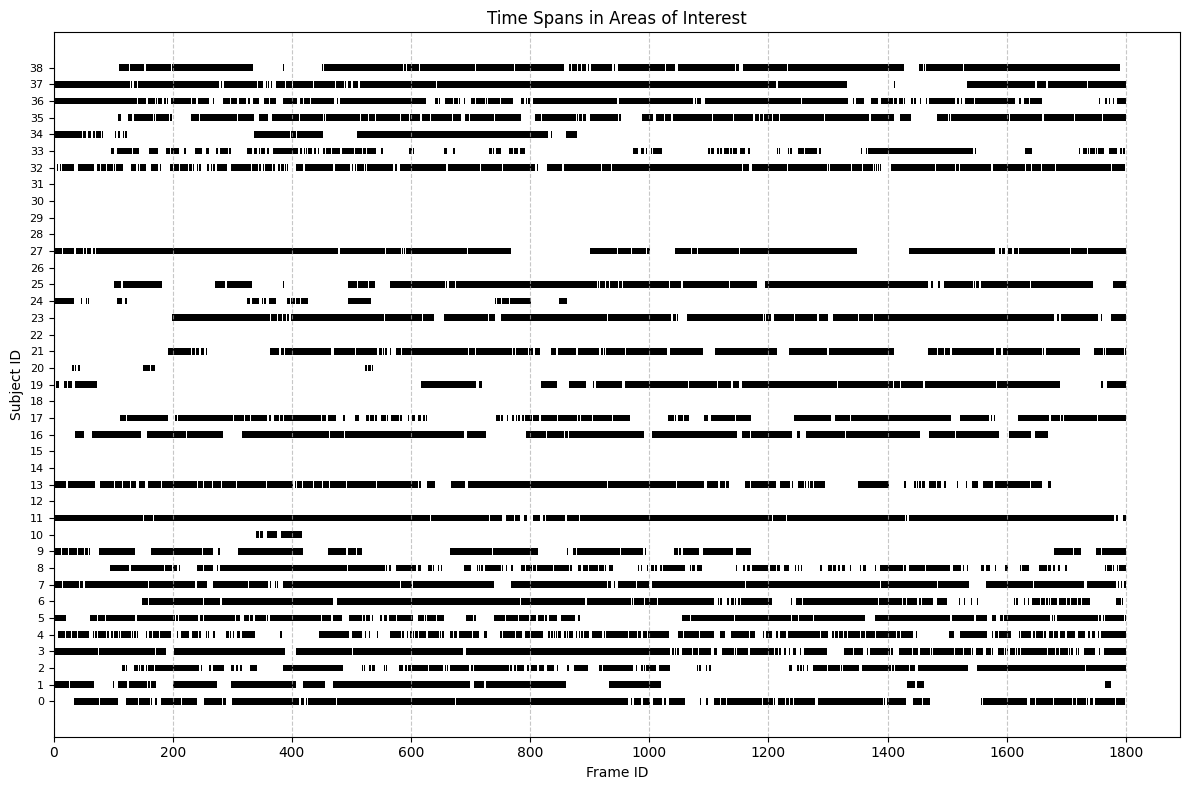

In [40]:
plot_timespans(df)

In [191]:
# Plotting the timespans with colors based on closest area

my_colormap =[ "navy" ,"crimson", "teal", "yellow"]

frames_per_second =5
def plot_timespans_with_taskpred(df):
    """Plot time spans for each subject with colors indicating areas."""
    unique_subjects =list(bibs.id)[10:20]
    starttime = datetime.datetime(2024,10,3,11,00,00).timestamp()

    fig, ax = plt.subplots(figsize=(12, 8))

    for i, subj_id in enumerate(unique_subjects):
        if subj_id % 5 ==0:
            print("working for subject: ",subj_id)
        subj_data = df[df['id'] == subj_id]
        for _, row in subj_data.iterrows():
#            color = "black"
            color = my_colormap[row["pred_label"]]
            if row['unixtime']-starttime < 600:
                ax.barh(
                    y=subj_id,
                    width=2.56,
                    left= row['unixtime']-starttime,
                    color=color,
                    height=0.4
                )

    ax.set_yticks(unique_subjects)
    ax.set_yticklabels(unique_subjects, fontsize=8)  # Adjust font size if needed

    # Create a legend without the 'Outside' area
#    handles = [plt.Line2D([0], [0], color=c, lw=4) for area, c in area_colors.items() if area != "Outside"]
#    labels = [area for area in area_colors.keys() if area != "Outside"]
#    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title="Areas")

    ax.set_xlabel('Frame ID')
    ax.set_ylabel('Subject ID')
    ax.set_title('Time Spans in Areas of Interest')
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Use ticker for consistent spacing on the x-axis
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

working for subject:  10
working for subject:  15


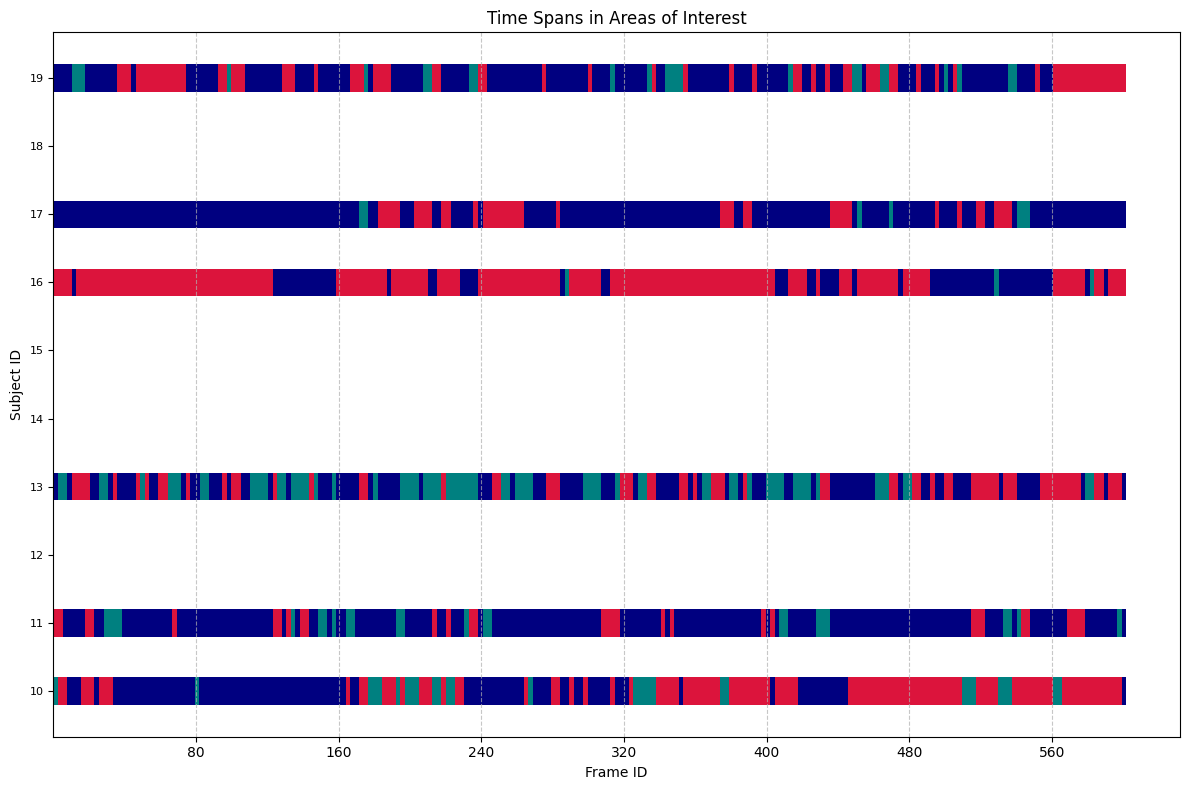

In [192]:
plot_timespans_with_taskpred(all_task)

In [ ]:
# わかっている速度を出してみたい
# 速度の出し方は、、、 pixel/sec かな。。。

In [171]:
colormap = plt.colormaps['jet']


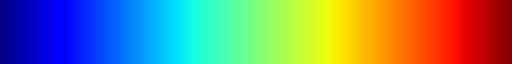

In [181]:
colormap

In [186]:
df['speed'].min()


0.0

In [197]:
my_colormap =[ "navy" ,"crimson", "teal", "yellow"]

                       
frames_per_second =5
def plot_timespans_with_taskpred_with_movespeed(movedf, taskdf):
    """Plot time spans for each subject with colors indicating areas."""
    unique_subjects =list(bibs.id)[30:]
    starttime = datetime.datetime(2024,10,3,11,00,00).timestamp()

    fig, ax = plt.subplots(figsize=(12, 8))

    for i, subj_id in enumerate(unique_subjects):
        if subj_id % 5 ==0:
            print("working for subject: ",subj_id)
        subj_data = taskdf[taskdf['id'] == subj_id]
        for _, row in subj_data.iterrows():
#            color = "black"
            color = my_colormap[row["pred_label"]]
            if row['unixtime']-starttime < 600:
                ax.barh(
                    y=subj_id,
                    width=2.56,
                    left= row['unixtime']-starttime,
                    color=color,
                    height=0.4
                )

        subj_data = movedf[movedf['subj_id'] == subj_id]
        for _, row in subj_data.iterrows():
            if row['frame_id'] / frames_per_second > 600:
                continue
            color = colormap(row['speed']/100)
            ax.barh(
                y=subj_id+0.5,
                width=1,
                left=row['frame_id'] / frames_per_second,
                color=color,
                # edgecolor="black",
                height=0.4
            )
    
    ax.set_yticks(unique_subjects)
    ax.set_yticklabels(unique_subjects, fontsize=8)  # Adjust font size if needed

    # Create a legend without the 'Outside' area
#    handles = [plt.Line2D([0], [0], color=c, lw=4) for area, c in area_colors.items() if area != "Outside"]
#    labels = [area for area in area_colors.keys() if area != "Outside"]
#    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title="Areas")

    ax.set_xlabel('Frame ID')
    ax.set_ylabel('Subject ID')
    ax.set_title('Time Spans in Areas of Interest')
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Use ticker for consistent spacing on the x-axis
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

working for subject:  30
working for subject:  35


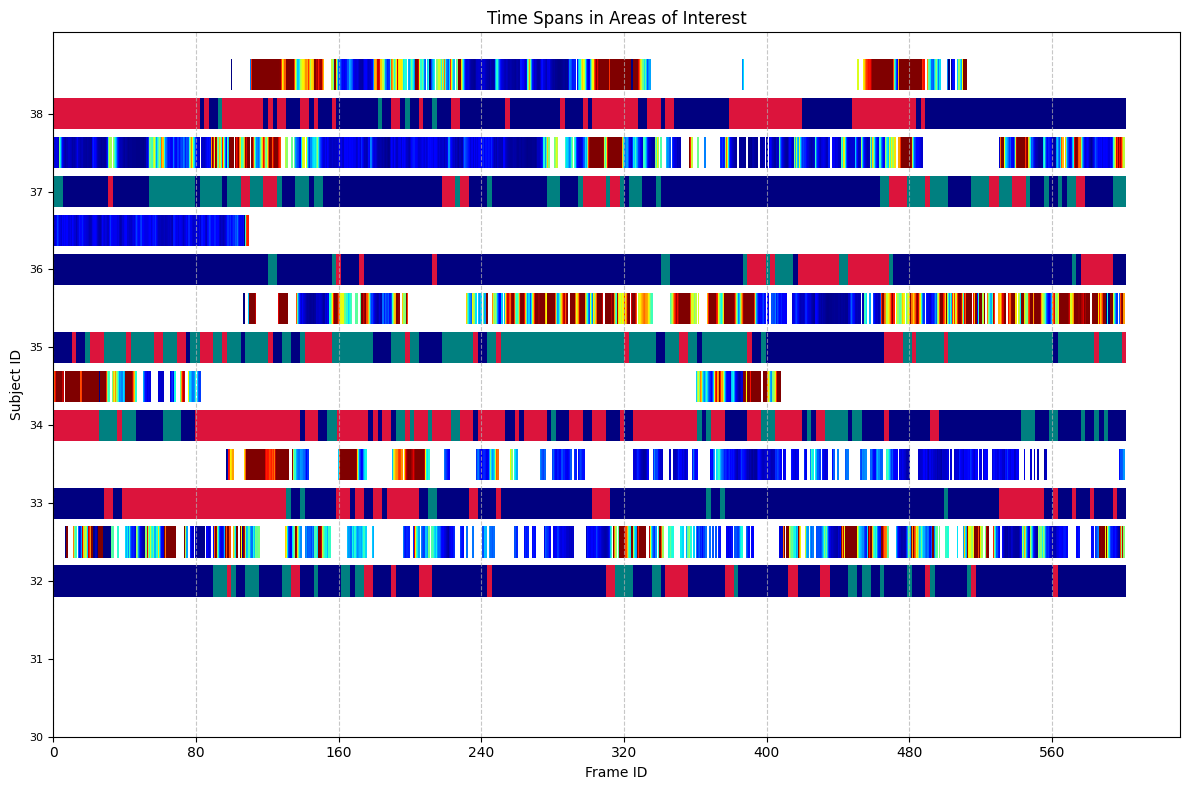

In [198]:
plot_timespans_with_taskpred_with_movespeed(df, all_task)

In [199]:

# track データも読みこんでみる

In [201]:
new_track_dir = "/mnt/bigdata/01_projects/2024_trusco/track_result/with_bibs/make_correct_json/"
workers = load_json_file(new_track_dir+"correct_tracking_result_2024-10-03_39600_43200_200_99_90_True_150_200_200_9985_10_True_90.json")


{'frame_id': 0,
 'tracks': [{'bbox': [6396.873580393333,
    1147.0703537528536,
    177.33611604328598,
    78.46063924672012],
   'score': 0.9394431114196777,
   'track_id': 1,
   'src_cam': 'A1',
   'subj_id': '11'},
  {'bbox': [5652.477090034255,
    1644.1776482098383,
    95.1275393805845,
    104.87419538290351],
   'score': 0.9233604669570923,
   'track_id': 2,
   'src_cam': 'A10',
   'subj_id': '37'},
  {'bbox': [5891.684121145686,
    1811.5078569184154,
    107.32375915429475,
    77.81484218905666],
   'score': 0.8442245125770569,
   'track_id': 3,
   'src_cam': 'A10',
   'subj_id': 'None'},
  {'bbox': [5634.994190137557,
    1893.205735995472,
    101.26708933457758,
    100.28615014417551],
   'score': 0.7939437031745911,
   'track_id': 4,
   'src_cam': 'A10',
   'subj_id': '36'},
  {'bbox': [5209.281147384101,
    1132.0292386837784,
    187.34219304897397,
    82.07558255074832],
   'score': 0.9123079776763916,
   'track_id': 5,
   'src_cam': 'A3',
   'subj_id': '24'},
